# Магнитное управление ориентацией космического аппарата

## Носырев Андрей (Б03-901)

## Постановка задачи
Уже десятилетия спутники применяют для решения широкого круга задач. Одной из таких задач является изучение гравитационного поля Земли и его временных вариаций. В 2002 году NASA в рамках миссии GRACE (Gravity Recovery and Climate Experiment) запустило два спутника, которые летают друг за другом на расстоянии 220 км. Спутки непрерывно обмениваются между собой радиосигналами в микроволновом диапазоне, что позволяет отслеживать расстояние между ними с микронной точностью. Это позволяет исследовать гравитационное поле Земли с высокой точностью.

Для обеспечения точных измерений относительного расстояния необходимо поддерживать прямую видимость между спутниками. Поскольку расстояние между ними достаточно велико, предъявляются жесткие требования к точности стабилизации ориентации: она должна быть менее 0,17 град. Для обычного спутника, оборудованного гироскопической системой ориентации, это не было бы проблемой. Однако использование этих механизмов неприемлемо для GRACE, поскольку они сильно повлияют на измерения, обеспечиваемые акселерометрами и системой измерения дальности. Следовательно, единственной системой управления ориентацией, которую можно использовать, является магнитная система.


# Алгоритм управления 

Ссылка на оригинальную статью, где можно посмотреть математические выкладки и ознакомиться с темой более детально: https://www.sciencedirect.com/science/article/pii/S009457652030223X#fd3.

Как упоминалось ранее, спутник должен быть стабилизирован в окрестности равновесия на протяжении всего полета, поэтому уравнения движения могут быть линеаризованы. Для описания движения спутника в таком случае удобно использовать углы Эйлера. Уравнения движения принимают вид:

\begin{array}{l}\dot\alpha\;=\;\omega,\\\dot\omega\;=A_\alpha\alpha\;+\;A_\omega\omega\;\end{array}

где $\alpha$ - вектор углов Эйлера, $\omega$ - вектор угловых скоростей, $A_\alpha$ и $A_\omega$ - следующие матрицы:

$A_\alpha\;=\omega_0^2\;\begin{pmatrix}4\frac{C-B}A&0&0\\0&3\frac{C-A}B&0\\0&0&\frac{A-B}C\end{pmatrix},\\A_\alpha\;=\omega_0^{}\;\begin{pmatrix}0&0&\frac{C+A-B}A\\0&0&0\\\frac{B-C-A}C&0&0\end{pmatrix}$

A, B, C - главные моменты инерции, $\omega_0$ - орбитальная угловая скорость вращения

Магнитное поле Земли в первом приближении можно рассматривать как диполь:

$B\;=\frac{\mu_B}{r^3}\;\begin{pmatrix}\cos u\sin i\\-\sin i\\2\sin u\sin i\end{pmatrix}$

где $\mu_B$ - магнитная постоянная, r - расстояние между ЦМ Земли и спутником, i - наклонение орбиты, u - аргумент широты

Поскольку спутник движется по круговой кеплеровской орбите, то i = const, r = const, u = $\omega_0$t + $u_0$. Таким образом магнитное поле будет меняться периодически, вследствие чего дальнейшие уравнения тоже будут периодическими (~1.57 часа для спутников миссии GRACE).

После выбора модели магнитного поля встает вопрос о выборе алгоритма определения необходимого магнитного момента катушек. В статье предложена следующая формула:

$m\;=\;\frac1{(B,\;B)}B\times M_{id}$

где $M_{id}$ - идеальный момент сил, требуемый контроллером. $M_{id}$ выводится с использованием соответствующей функции Ляпунова.

$M_{id}=\;-(JA_\alpha\alpha\;+\;JA_\omega\omega\;+\;K_\alpha\alpha\;+\;K_\omega\omega)$

К сожалению, из-за формулы для магнитного момента, действующего на диполь во внешнем магнитном поле (M = [m, B]), получение идеального управляющего вектора может быть осложнено или вообще невозможно. Поэтому авторами статьи предлагается следующая формула для управляющего момента:

$M_{gen}\;=\;M_{id}\;-\;e_B(e_B,M_{id}),\;\;e_B\;=\frac{\;B}{\sqrt{(B,\;B)}}$

Это означает, что управляющий момент есть проекция идеального момента на плоскость, перпендикулярную внешнему магнитному полю.

Наконец, запишем уравнения движения уже с учетом управляющего воздействия:

$\begin{array}{l}\dot\alpha\;=\;\omega,\\\dot\omega\;=A_\alpha\alpha\;+\;A_\omega\omega\;+\;J^{-1}{\lbrack e_B\rbrack}_x{\lbrack e_B\rbrack}_x(JA_\alpha\alpha\;+\;JA_\omega\omega\;+\;K_\alpha\alpha\;+\;K_\omega\omega)\end{array}$

где оператор $[e]_x$ определён следующим образом:

${\lbrack e\rbrack}_x\;=\;\begin{pmatrix}0&-e_3&e_2\\e_3&0&-e_1\\-e_2&e_1&0\end{pmatrix}$

Матрицы  $K_\alpha$ и $K_\omega$ - это диагональные матрицы, коэффициенты которых подбираются таким образом, чтобы положение равновесия было наиболее асимптотически устойчиво. Специльный алгоритм для этого можно найти в оригинальной статье.

# Реализация метода управления на Python

In [3]:
# Подключаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math as m

In [4]:
# Константы
M_Earth = 5.9722e24  # kg
G = 6.67430e-11  # m^3 * kg^-1 * s^-2

In [5]:
# Вспомогательные функции
def normalize(obj):
    return obj / np.linalg.norm(obj)

def cross_product(a, b):
    return np.array([a[1] * b[2] - a[2] * b[1], a[2] * b[0] - a[0] * b[2], a[0] * b[1] - a[1] * b[0]])

def get_skew_symmetric_matrix_of_cross_product(vec):
    return np.array([[0, -vec[2], vec[1]], [vec[2], 0, -vec[0]], [-vec[1], vec[0], 0]])


In [6]:
# Подсчёт управляющего момента
def ctrl_torque(angles, omega, ctrl, sat, B, calc_m):
    # Идельный управляющий момент  
    trq_ideal = sat.J.dot(sat.A_alpha.dot(angles) + sat.A_omega.dot(omega)) + ctrl.K_alpha.dot(
        angles) + ctrl.K_omega.dot(omega)
    e_B = normalize(B) # по определению e_B
    e_B_x = get_skew_symmetric_matrix_of_cross_product(e_B) # берем кососимметрическую матрицу
    trq_ctrl = e_B_x.dot(e_B_x.dot(trq_ideal))

    # Используется уже после вычислений, чтобы посмотреть каких значений достигали магнитные моменты катушек
    if calc_m:
        return trq_ctrl, cross_product(B, trq_ideal) / np.dot(B, B)

    return trq_ctrl

In [7]:
# Функция для подсчёта внешнего поля Земли
def calc_B(r, i, u):
    mu_B = 7.812e6  # km^3*kg*s^-2*A^-1, Earth magnetic constant
    return mu_B / r ** 3 * np.array([m.cos(u) * m.sin(i), -m.cos(i), 2 * m.sin(u) * m.sin(i)])

In [8]:
# Правая часть системы
def rhs(t, x, sat, ctrl):
    angles = x[:3]
    omega = x[3:6]

    B = calc_B(sat.r, sat.i, sat.omega_0 * t)

    control_action = sat.J_inv.dot(ctrl_torque(angles, omega, ctrl, sat, B, False))

    x_dot = np.zeros(6)
    x_dot[:3] = omega
    x_dot[3:6] = sat.A_alpha.dot(angles) + sat.A_omega.dot(omega) + control_action

    return x_dot

In [9]:
# Из определения матрицы A_alpha
def calc_A_alpha(A, B, C, omega_0):
    return omega_0 * omega_0 * np.diag(np.array([4 * (C - B) / A, 3 * (C - A) / B, (A - B) / C]))

# Из определения матрицы A_omega
def calc_A_omega(A, B, C, omega_0):
    result = np.zeros((3, 3))
    result[0, 2] = (C + A - B) / A
    result[2, 0] = (B - C - A) / C
    return result * omega_0

In [10]:
class Parameters(object):
    pass


# Данные о спутнике
sat = Parameters()
sat.J = np.diag(np.array([110.4, 580.5, 649.5]))  # kg*m^2, взято с реального спутника GRACE
sat.J_inv = np.linalg.inv(sat.J)

sat.r = 6862  # km, orbit radius, взято с реального спутника GRACE
sat.omega_0 = m.sqrt(G * M_Earth / ((sat.r * 1000) ** 3))  # s^-1, orbital angular velocity
sat.i = 89 * m.pi / 180  # orbit inclination, взято с реального спутника GRACE

sat.A_alpha = calc_A_alpha(sat.J[0, 0], sat.J[1, 1], sat.J[2, 2], sat.omega_0)
sat.A_omega = calc_A_omega(sat.J[0, 0], sat.J[1, 1], sat.J[2, 2], sat.omega_0)

In [11]:
# Данные об управлении
ctrl = Parameters()
# Эти к-ты были предложены в статье. Они были посчитаны по алгоритму, который любознательный читатель может найти в п. 3.4 статьи
ctrl.K_alpha = np.diag(np.array([0.0012, 0.0030, -0.0005]))  # N*m
ctrl.K_omega = np.diag(np.array([1.05, 3.1, 0.33]))  # N*m*s

In [12]:
# Начальные условия
alpha_0 = 10 * m.pi / 180
x_0 = np.array([alpha_0, -alpha_0, 2 * alpha_0, 0, 0, 0])

In [13]:
# Сетка по времени
t0 = 0.
tf = 5 * 3600.
t_eval = np.arange(t0, tf, 10)

# Решаем нашу системы уравнений
sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0, tf), x_0, t_eval=t_eval)


In [14]:
# Достаем данные для визуализации

x = sol.y.T
t = sol.t

control = np.zeros((np.size(t), 3))
magnetic_moment = np.zeros((np.size(t), 3))
for i in range(np.size(t)):
    B = calc_B(sat.r, sat.i, sat.omega_0 * t[i])
    control[i], magnetic_moment[i] = ctrl_torque(x[i, 0:3], x[i, 3:6], ctrl, sat, B, True)

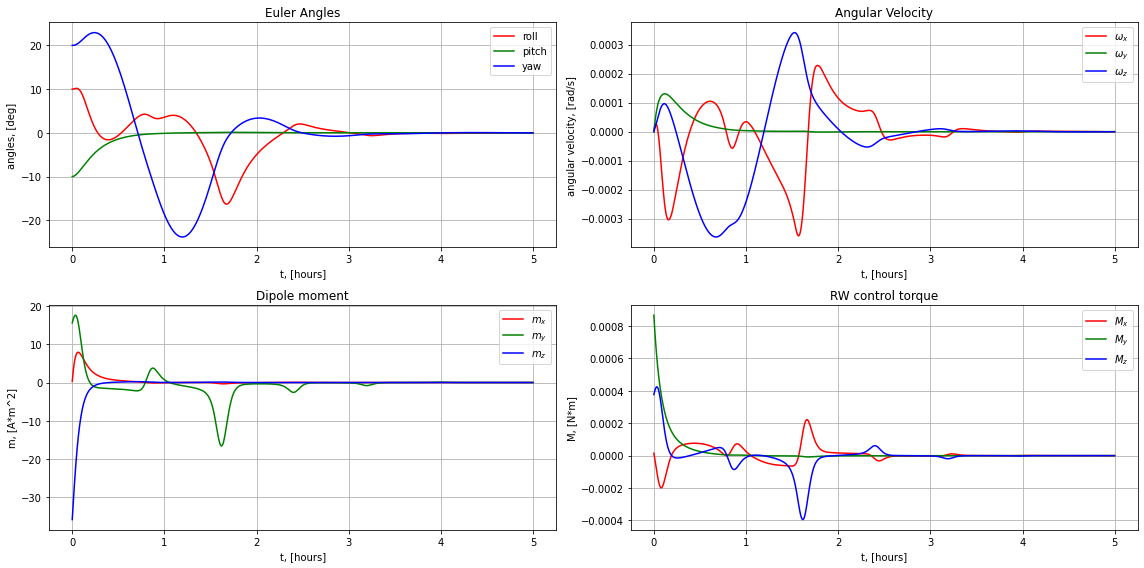

In [15]:
# Строим графики
fig1 = plt.figure(figsize=(16, 8))
ax1 = fig1.add_subplot(2, 2, 1)

t /= 3600

ax1.set_title("Euler Angles")
ax1.plot(t, x[:, 0] * 180 / m.pi, label='roll', color='red')
ax1.plot(t, x[:, 1] * 180 / m.pi, label='pitch', color='green')
ax1.plot(t, x[:, 2] * 180 / m.pi, label='yaw', color='blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [hours]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2, 2, 2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:, 3], label='$\omega_x$', color='red')
ax2.plot(t, x[:, 4], label='$\omega_y$', color='green')
ax2.plot(t, x[:, 5], label='$\omega_z$', color='blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [hours]')
ax2.grid(True)
ax2.legend()

ax3 = fig1.add_subplot(2, 2, 3)

ax3.set_title("Dipole moment")
ax3.plot(t, magnetic_moment[:, 0], label='$m_x$', color='red')
ax3.plot(t, magnetic_moment[:, 1], label='$m_y$', color='green')
ax3.plot(t, magnetic_moment[:, 2], label='$m_z$', color='blue')
ax3.set_ylabel(r'm, [A*m^2]')
ax3.set_xlabel(r't, [hours]')
ax3.grid(True)
ax3.legend()

ax4 = fig1.add_subplot(2, 2, 4)

ax4.set_title("Сontrol torque")
ax4.plot(t, control[:, 0], label='$M_x$', color='red')
ax4.plot(t, control[:, 1], label='$M_y$', color='green')
ax4.plot(t, control[:, 2], label='$M_z$', color='blue')
ax4.set_ylabel(r'M, [N*m]')
ax4.set_xlabel(r't, [hours]')
ax4.grid(True)
ax4.legend()

plt.tight_layout()